In [314]:
import pandas as pd
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
from sklearn.discriminant_analysis import StandardScaler
import matplotlib.pyplot as plt
from  src.utils.load_dataframe import load_time_series_60min


In [315]:
# Load the data
data = load_time_series_60min()


In [316]:
# Filter relevant columns
columns_of_interest = ['DE_solar_generation_actual', 'DE_wind_generation_actual', 'DE_load_actual_entsoe_transparency', 'DE_LU_price_day_ahead']
data = data[columns_of_interest]
data = data.resample('W').mean()
data.head(10)

,DE_solar_generation_actual,DE_wind_generation_actual,DE_load_actual_entsoe_transparency,DE_LU_price_day_ahead
utc_timestamp,,,,
2015-01-04 00:00:00+00:00,585.101124,18507.260417,47233.739583,NaN
2015-01-11 00:00:00+00:00,787.077381,17309.958333,56191.101190,NaN
2015-01-18 00:00:00+00:00,1024.113095,15602.815476,57672.678571,NaN
2015-01-25 00:00:00+00:00,578.154762,2787.720238,58613.303571,NaN
2015-02-01 00:00:00+00:00,779.095238,10045.607143,58734.029762,NaN
2015-02-08 00:00:00+00:00,1514.208333,7860.023810,59323.898810,NaN
2015-02-15 00:00:00+00:00,1788.273810,5923.273810,58137.779762,NaN
2015-02-22 00:00:00+00:00,2295.869048,8410.101190,57802.898810,NaN
2015-03-01 00:00:00+00:00,2499.298611,10484.994048,58862.452381,NaN


In [317]:
missing_values = data.isnull().sum()
print(missing_values)

DE_solar_generation_actual              0
DE_wind_generation_actual               0
DE_load_actual_entsoe_transparency      0
DE_LU_price_day_ahead                 195
dtype: int64


In [318]:
# Imputar los valores faltantes con la media
data['DE_solar_generation_actual'] = data['DE_solar_generation_actual'].fillna(data['DE_solar_generation_actual'].mean())
data['DE_wind_generation_actual'] = data['DE_wind_generation_actual'].fillna(data['DE_wind_generation_actual'].mean())

# Interpolar los valores faltantes en DE_LU_price_day_ahead
data['DE_LU_price_day_ahead'] = data['DE_LU_price_day_ahead'].interpolate()

In [319]:
missing_values = data.isnull().sum()
print(missing_values)

DE_solar_generation_actual              0
DE_wind_generation_actual               0
DE_load_actual_entsoe_transparency      0
DE_LU_price_day_ahead                 195
dtype: int64


In [320]:
from sklearn.linear_model import LinearRegression

# Create a DataFrame where the 'DE_LU_price_day_ahead' column has non-null values
train_data = data.dropna(subset=['DE_LU_price_day_ahead'])

# Define predictor variables
X_train_reg = train_data[['DE_solar_generation_actual', 'DE_wind_generation_actual', 'DE_load_actual_entsoe_transparency']]
y_train_reg = train_data['DE_LU_price_day_ahead']

# Train the regression model
model_reg = LinearRegression()
model_reg.fit(X_train_reg, y_train_reg)

# Predict the missing values in the 'DE_LU_price_day_ahead' column
X_missing = data[data['DE_LU_price_day_ahead'].isna()][['DE_solar_generation_actual', 'DE_wind_generation_actual', 'DE_load_actual_entsoe_transparency']]
y_pred_missing = model_reg.predict(X_missing)

# Replace missing values with predictions
data.loc[data['DE_LU_price_day_ahead'].isna(), 'DE_LU_price_day_ahead'] = y_pred_missing

# Check for any remaining missing values
print(data.isnull().sum())


DE_solar_generation_actual            0
DE_wind_generation_actual             0
DE_load_actual_entsoe_transparency    0
DE_LU_price_day_ahead                 0
dtype: int64


In [321]:
data.head(10)
data.describe()

,DE_solar_generation_actual,DE_wind_generation_actual,DE_load_actual_entsoe_transparency,DE_LU_price_day_ahead
count,301.000000,301.000000,301.000000,301.000000
mean,4556.280329,11542.128955,55484.350477,41.217356
std,2682.507509,6254.377718,3762.742475,10.169936
min,393.994048,2519.357143,46505.309524,11.386726
25%,1808.857143,6933.148810,52845.267857,35.828739
50%,4798.964286,10284.648810,54858.434524,41.153155
75%,6674.619048,14324.654762,58688.470238,46.627556
max,10471.017857,36032.940476,63587.011905,68.079935


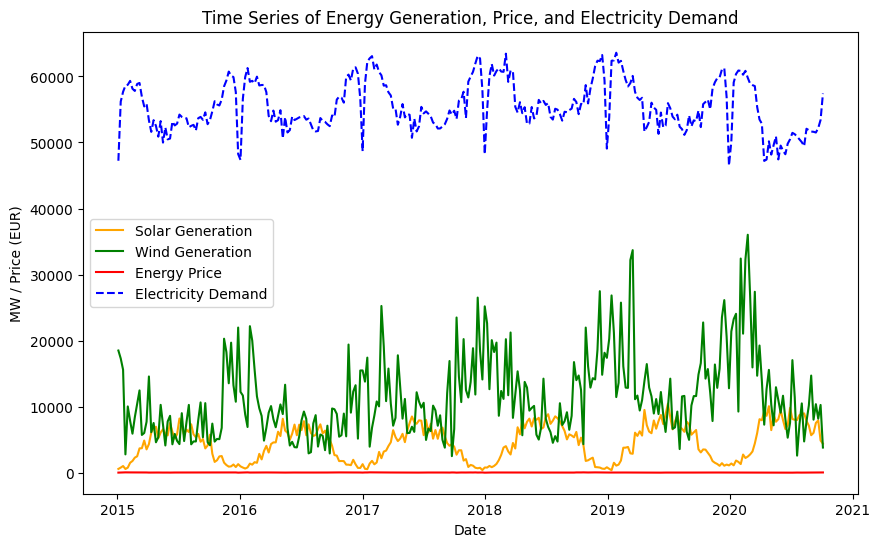

In [322]:
# Assign specific colors to each series
plt.figure(figsize=(10, 6))
# Solar Generation in blue
plt.plot(data.index, data['DE_solar_generation_actual'], label='Solar Generation', color='orange')
# Wind Generation in orange
plt.plot(data.index, data['DE_wind_generation_actual'], label='Wind Generation', color='green')
# Energy Price in red
plt.plot(data.index, data['DE_LU_price_day_ahead'], label='Energy Price', color='red')
# Electricity Demand in blue (dashed line)
plt.plot(data.index, data['DE_load_actual_entsoe_transparency'], label='Electricity Demand', color='blue', linestyle='--')
# Title and axis labels
plt.title('Time Series of Energy Generation, Price, and Electricity Demand')
plt.xlabel('Date')
plt.ylabel('MW / Price (EUR)')
plt.legend()
plt.show()

In [323]:
data = data.resample('W').mean()

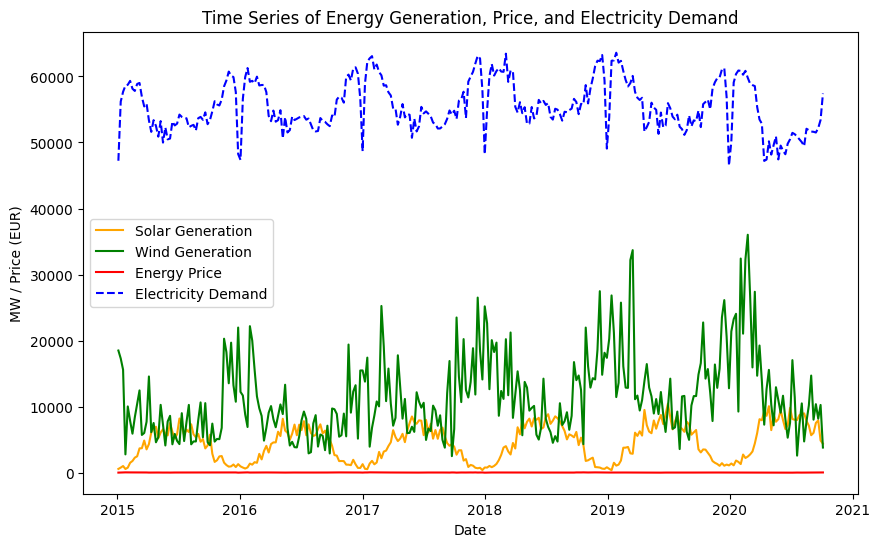

In [324]:
plt.figure(figsize=(10, 6))
plt.plot(data.index, data['DE_solar_generation_actual'], label='Solar Generation', color='orange')
plt.plot(data.index, data['DE_wind_generation_actual'], label='Wind Generation', color='green')
plt.plot(data.index, data['DE_LU_price_day_ahead'], label='Energy Price', color='red')
plt.plot(data.index, data['DE_load_actual_entsoe_transparency'], label='Electricity Demand', linestyle='--', color='blue')
plt.title('Time Series of Energy Generation, Price, and Electricity Demand')
plt.xlabel('Date')
plt.ylabel('MW / Price (EUR)')
plt.legend()
plt.show()

In [325]:
# Split features (X) and target variable (y)
X = data[['DE_solar_generation_actual', 'DE_wind_generation_actual','DE_LU_price_day_ahead']]
y = data['DE_load_actual_entsoe_transparency']


In [326]:
# Split the dataset into training and test sets (80% training, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35, random_state=42)


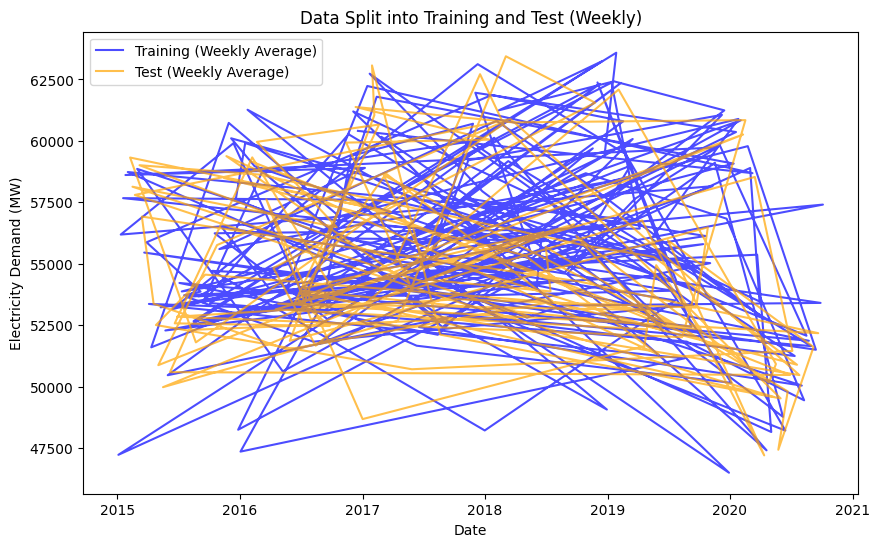

In [327]:
# Plot again after sorting
plt.figure(figsize=(10, 6))
plt.plot(y_train.index, y_train, label='Training (Weekly Average)', color='blue', alpha=0.7)
plt.plot(y_test.index, y_test, label='Test (Weekly Average)', color='orange', alpha=0.7)
plt.title('Data Split into Training and Test (Weekly)')
plt.xlabel('Date')
plt.ylabel('Electricity Demand (MW)')
plt.legend()
plt.show()

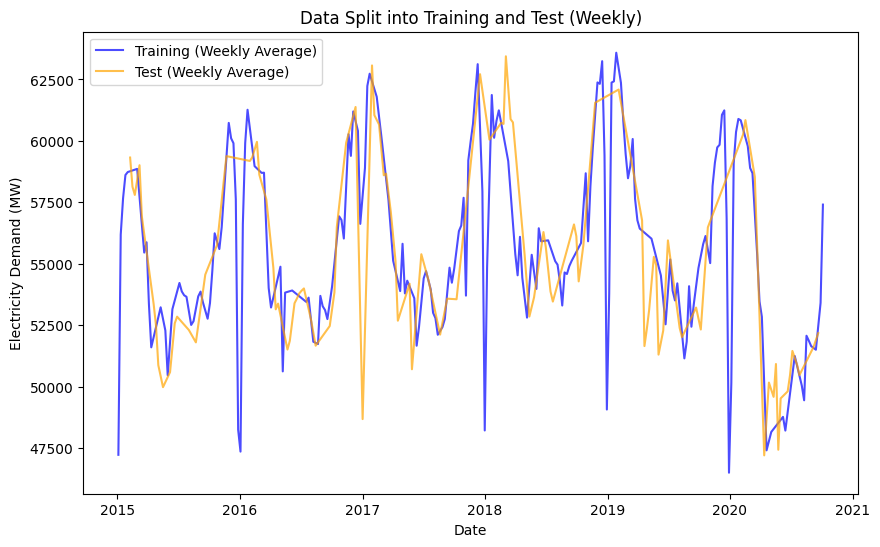

In [328]:
# Ensure the data is sorted by date
X_train = X_train.sort_index()
X_test = X_test.sort_index()
y_train = y_train.sort_index()
y_test = y_test.sort_index()


plt.figure(figsize=(10, 6))
plt.plot(y_train.index, y_train, label='Training (Weekly Average)', color='blue', alpha=0.7)
plt.plot(y_test.index, y_test, label='Test (Weekly Average)', color='orange', alpha=0.7)
plt.title('Data Split into Training and Test (Weekly)')
plt.xlabel('Date')
plt.ylabel('Electricity Demand (MW)')
plt.legend()
plt.show()

In [329]:
print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")

Training set: (195, 3)
Test set: (106, 3)


# Data Distribution

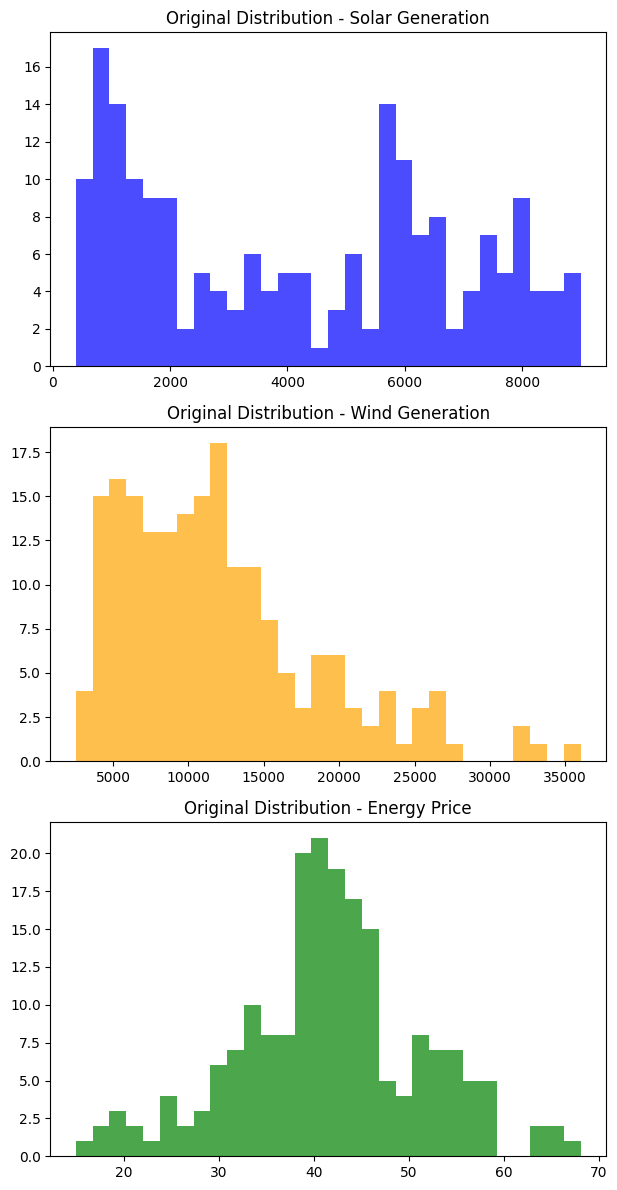

In [330]:
plt.figure(figsize=(12, 12))

# Histogram for Solar Generation (before normalization)
plt.subplot(3, 2, 1)
plt.hist(X_train['DE_solar_generation_actual'], bins=30, color='blue', alpha=0.7)
plt.title('Original Distribution - Solar Generation')

# Histogram for Wind Generation (before normalization)
plt.subplot(3, 2, 3)
plt.hist(X_train['DE_wind_generation_actual'], bins=30, color='orange', alpha=0.7)
plt.title('Original Distribution - Wind Generation')

# Histogram for Energy Price (before normalization)
plt.subplot(3, 2, 5)
plt.hist(X_train['DE_LU_price_day_ahead'], bins=30, color='green', alpha=0.7)
plt.title('Original Distribution - Energy Price')

plt.tight_layout()
plt.show()


# Apply Yeo-Johnson data normalization method and standardize the data with StandardScaler


First rows of scaled X_train:
[[ 0.62085328 -0.03050294 -0.18020713]
 [ 1.10544784 -1.56800937 -0.05877571]
 [ 1.01863902 -0.12708989 -0.34448765]
 [-1.45820374  0.21778778  1.67551624]
 [-0.76684268  1.56942342 -0.93432534]]
First rows of scaled X_test:
[[ 1.33425199 -0.06963574 -0.8967903 ]
 [ 1.26622661 -2.40174243 -0.58398098]
 [ 1.24919376 -0.2889774  -0.22042738]
 [ 0.20431647 -1.55748001  2.37390679]
 [-0.30333752 -0.13636749  1.02341098]]


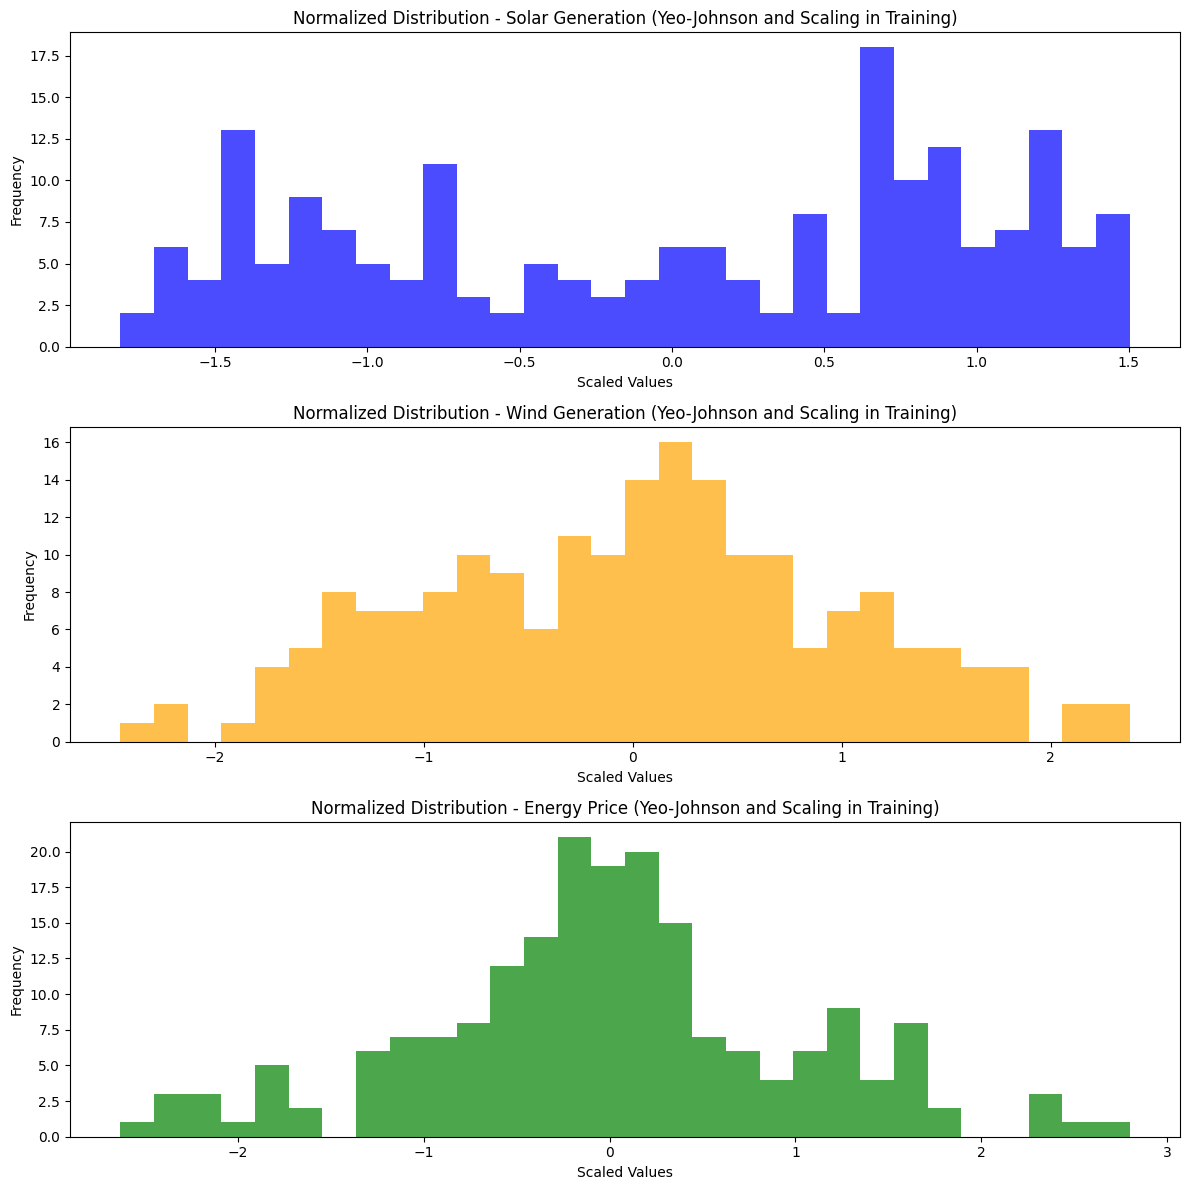

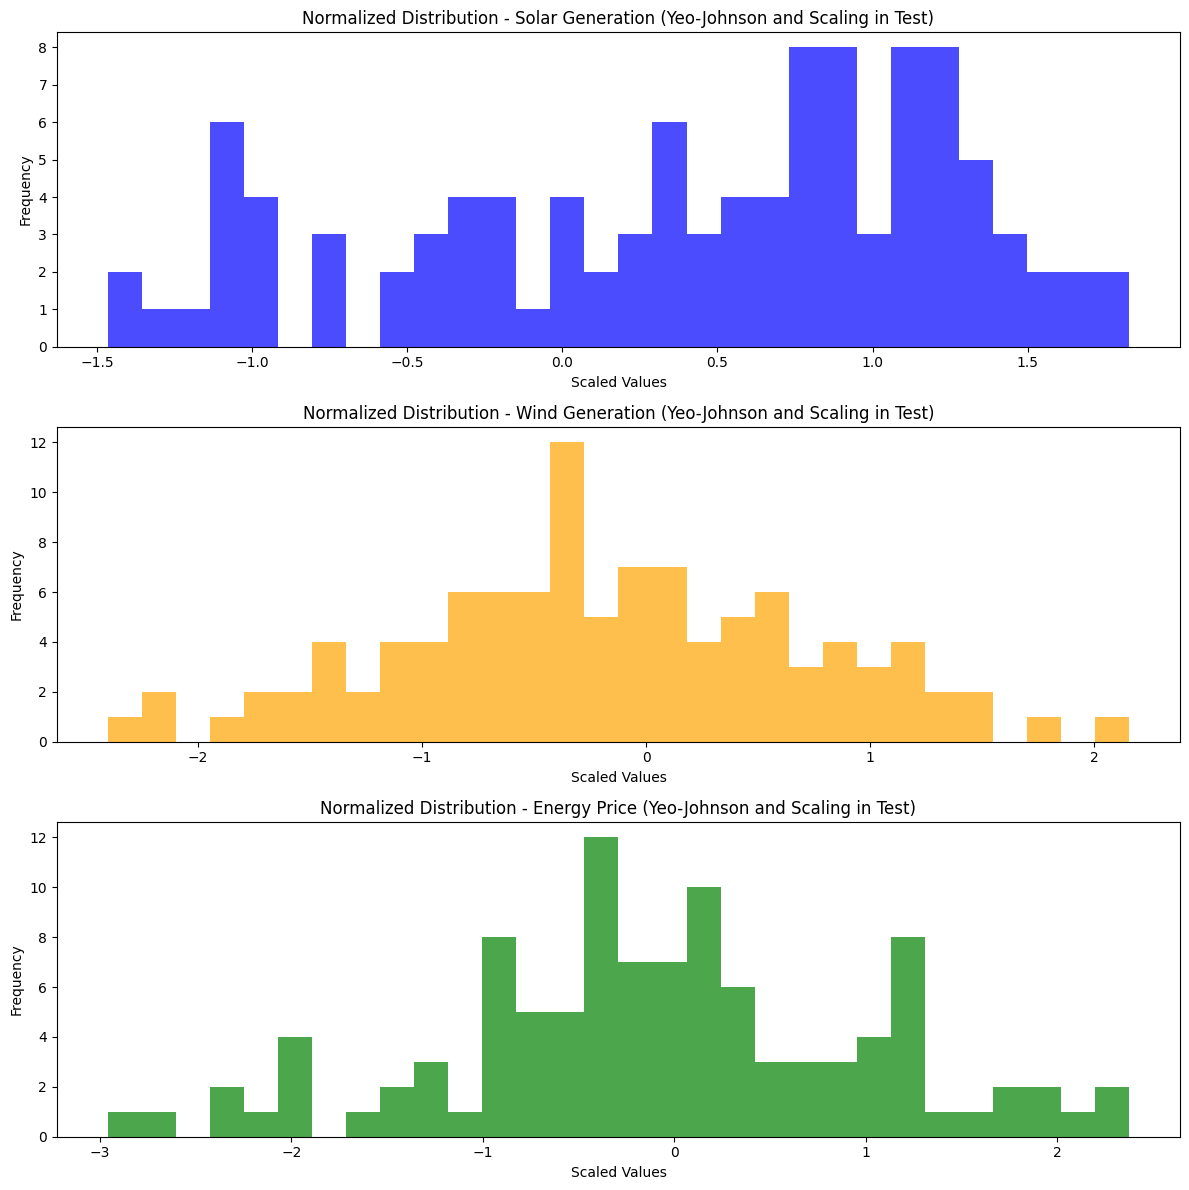

In [331]:
from sklearn.preprocessing import PowerTransformer, StandardScaler
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

# Split data into training (train) and test (test)
X_train, X_test, y_train, y_test = train_test_split(
    data[['DE_solar_generation_actual', 'DE_wind_generation_actual', 'DE_LU_price_day_ahead']],
    data['DE_load_actual_entsoe_transparency'],
    test_size=0.35,
    random_state=42
)

# Step 1: Apply Yeo-Johnson transformation by fitting only on X_train
transformer = PowerTransformer(method='yeo-johnson')
X_train_yeo_johnson = transformer.fit_transform(X_train)  # Fit and transform X_train
X_test_yeo_johnson = transformer.transform(X_test)  # Only transform X_test (no re-fitting)

# Step 2: Scale the data after transformation (fit only on X_train)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_yeo_johnson)  # Fit and scale X_train
X_test_scaled = scaler.transform(X_test_yeo_johnson)  # Only scale X_test (no re-fitting)

# Show the first transformed and scaled rows
print("First rows of scaled X_train:")
print(X_train_scaled[:5])

print("First rows of scaled X_test:")
print(X_test_scaled[:5])

# Plot distributions of training data after transformation and scaling
plt.figure(figsize=(12, 12))

# Solar Generation
plt.subplot(3, 1, 1)
plt.hist(X_train_scaled[:, 0], bins=30, color='blue', alpha=0.7)
plt.title('Normalized Distribution - Solar Generation (Yeo-Johnson and Scaling in Training)')
plt.xlabel('Scaled Values')
plt.ylabel('Frequency')

# Wind Generation
plt.subplot(3, 1, 2)
plt.hist(X_train_scaled[:, 1], bins=30, color='orange', alpha=0.7)
plt.title('Normalized Distribution - Wind Generation (Yeo-Johnson and Scaling in Training)')
plt.xlabel('Scaled Values')
plt.ylabel('Frequency')

# Energy Price
plt.subplot(3, 1, 3)
plt.hist(X_train_scaled[:, 2], bins=30, color='green', alpha=0.7)
plt.title('Normalized Distribution - Energy Price (Yeo-Johnson and Scaling in Training)')
plt.xlabel('Scaled Values')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# You can also plot the test data if needed:
plt.figure(figsize=(12, 12))

# Solar Generation (Test)
plt.subplot(3, 1, 1)
plt.hist(X_test_scaled[:, 0], bins=30, color='blue', alpha=0.7)
plt.title('Normalized Distribution - Solar Generation (Yeo-Johnson and Scaling in Test)')
plt.xlabel('Scaled Values')
plt.ylabel('Frequency')

# Wind Generation (Test)
plt.subplot(3, 1, 2)
plt.hist(X_test_scaled[:, 1], bins=30, color='orange', alpha=0.7)
plt.title('Normalized Distribution - Wind Generation (Yeo-Johnson and Scaling in Test)')
plt.xlabel('Scaled Values')
plt.ylabel('Frequency')

# Energy Price (Test)
plt.subplot(3, 1, 3)
plt.hist(X_test_scaled[:, 2], bins=30, color='green', alpha=0.7)
plt.title('Normalized Distribution - Energy Price (Yeo-Johnson and Scaling in Test)')
plt.xlabel('Scaled Values')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [332]:
# Convert data to DMatrix format for XGBoost
train_dmatrix = xgb.DMatrix(X_train_scaled, label=y_train)
test_dmatrix = xgb.DMatrix(X_test_scaled, label=y_test)

In [333]:
# Model parameters
params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'max_depth': 5,
    'learning_rate': 0.1
}

In [334]:
# Train the model
xg_reg = xgb.train(params, train_dmatrix, num_boost_round=100)


In [335]:
# Predict
y_pred = xg_reg.predict(test_dmatrix)

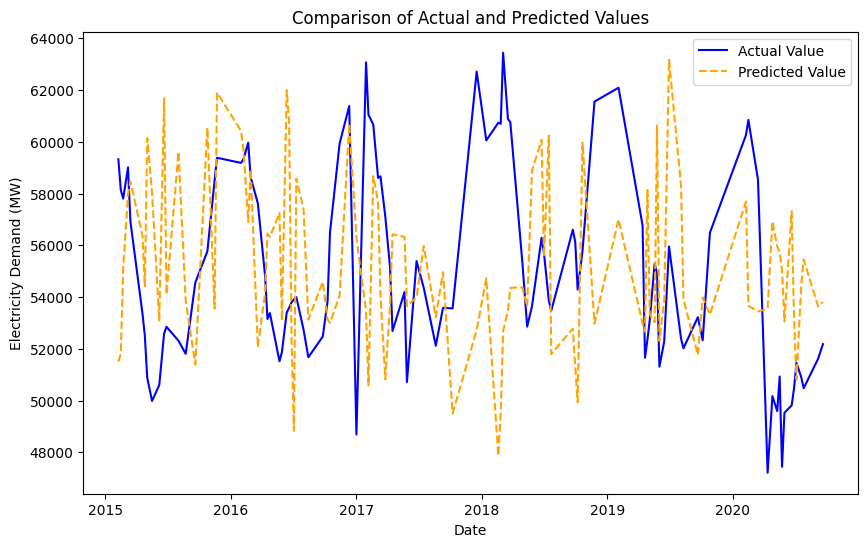

In [336]:
# Ensure the data is sorted by date
X_train = X_train.sort_index()
X_test = X_test.sort_index()
y_train = y_train.sort_index()
y_test = y_test.sort_index()

plt.figure(figsize=(10, 6))
plt.plot(y_test.index, y_test, label='Actual Value', color='blue')
plt.plot(y_test.index, y_pred, label='Predicted Value', color='orange', linestyle='--')
plt.title('Comparison of Actual and Predicted Values')
plt.xlabel('Date')
plt.ylabel('Electricity Demand (MW)')
plt.legend()
plt.show()

In [337]:
# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

mean_real_load = data['DE_load_actual_entsoe_transparency'].mean()
# Convert MAE and RMSE to a percentage of the average consumption
mae_pct = (mae / mean_real_load) * 100
rmse_pct = (rmse / mean_real_load) * 100

# Print results as a percentage
print(f"Mean Absolute Error (MAE): {mae} ({mae_pct:.2f}% of average consumption)")
print(f"Root Mean Squared Error (RMSE): {rmse} ({rmse_pct:.2f}% of average consumption)")

Mean Absolute Error (MAE): 4153.836070867026
Root Mean Squared Error (RMSE): 5057.382167739348
Mean Absolute Error (MAE): 4153.836070867026 (7.49% of average consumption)
Root Mean Squared Error (RMSE): 5057.382167739348 (9.11% of average consumption)


# Model Improvement

In [338]:
# Base parameters that will be varied
params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse'
}

In [339]:
# Hyperparameter ranges
max_depth_range = [3, 5, 7, 10]  # Tree depth
learning_rate_range = [0.01, 0.05, 0.1, 0.2]  # Learning rate
n_estimators_range = [50, 100, 200]  # Number of trees

In [340]:
# Variables to store the best result
best_rmse = float('inf')
best_params = {}

# List to store RMSE results
rmse_results = []

In [341]:
# List to store RMSE results
rmse_results = []

# Loop over the different values
for learning_rate in learning_rate_range:
    rmse_per_depth = []  # Store RMSE for each max_depth and learning_rate
    for max_depth in max_depth_range:
        rmse_sum = 0  # Sum the RMSE for averaging over n_estimators
        for n_estimators in n_estimators_range:
            
            # Update the parameters
            params['max_depth'] = max_depth
            params['learning_rate'] = learning_rate
            params['n_estimators'] = n_estimators
            
            # Create the model with current parameters
            model = xgb.XGBRegressor(**params)
            
            # Train the model
            model.fit(X_train, y_train)
            
            # Make predictions
            y_pred = model.predict(X_test)
            
            # Calculate RMSE
            rmse = np.sqrt(mean_squared_error(y_test, y_pred))
            
            # Sum the RMSE for this combination
            rmse_sum += rmse
            
            # Print the results for this set of parameters
            print(f"max_depth: {max_depth}, learning_rate: {learning_rate}, n_estimators: {n_estimators}, RMSE: {rmse}")
        
        # Store the average RMSE over n_estimators for this combination of max_depth and learning_rate
        rmse_per_depth.append(rmse_sum / len(n_estimators_range))


max_depth: 3, learning_rate: 0.01, n_estimators: 50, RMSE: 3078.7556284148563
max_depth: 3, learning_rate: 0.01, n_estimators: 100, RMSE: 2675.9821100700824
max_depth: 3, learning_rate: 0.01, n_estimators: 200, RMSE: 2311.926160091686
max_depth: 5, learning_rate: 0.01, n_estimators: 50, RMSE: 2999.0812105345967
max_depth: 5, learning_rate: 0.01, n_estimators: 100, RMSE: 2478.0272964351498
max_depth: 5, learning_rate: 0.01, n_estimators: 200, RMSE: 2108.7021683601856
max_depth: 7, learning_rate: 0.01, n_estimators: 50, RMSE: 2982.341236241783
max_depth: 7, learning_rate: 0.01, n_estimators: 100, RMSE: 2518.3411321566964
max_depth: 7, learning_rate: 0.01, n_estimators: 200, RMSE: 2200.453822214381
max_depth: 10, learning_rate: 0.01, n_estimators: 50, RMSE: 2945.173140442849
max_depth: 10, learning_rate: 0.01, n_estimators: 100, RMSE: 2472.461831570221
max_depth: 10, learning_rate: 0.01, n_estimators: 200, RMSE: 2145.062718744325
max_depth: 3, learning_rate: 0.05, n_estimators: 50, RMSE: 

In [342]:
print(f"Size of rmse_results: {len(rmse_results)}")
for i, result in enumerate(rmse_results):
    print(f"Results for learning_rate={learning_rate_range[i]}: {result}")

Size of rmse_results: 0


In [343]:
# Store the RMSE for this learning rate
rmse_results.append(rmse_per_depth)

In [344]:
# Final results
print(f"Best RMSE: {best_rmse}")
print(f"Best parameters: {best_params}")

Best RMSE: inf
Best parameters: {}


# After finding the best settings for the model, we will do cross-validation.

In [345]:
from sklearn.model_selection import cross_val_score
import xgboost as xgb
from sklearn.metrics import make_scorer, mean_squared_error

In [346]:
# Define the model with the best parameters found
model = xgb.XGBRegressor(
    objective='reg:squarederror',
    eval_metric='rmse',
    max_depth=3,
    learning_rate=0.1,
    n_estimators=100
)


In [347]:
# Define the scorer using RMSE
rmse_scorer = make_scorer(mean_squared_error, squared=False)

In [348]:
# Run cross-validation (5 folds)
cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring=rmse_scorer)


C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean s

In [349]:
# Show the results
print(f"RMSE in each fold: {cv_scores}")
print(f"Average RMSE: {cv_scores.mean()}")
print(f"RMSE Standard Deviation: {cv_scores.std()}")

RMSE in each fold: [2154.49196237 1699.90324433 2419.2700252  2712.52181647 3263.18464653]
Average RMSE: 2449.8743389821766
RMSE Standard Deviation: 525.5666216674242


# Hyperparameter Optimization

In [350]:
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

In [351]:
# Define the parameters to tune
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [50, 100, 200],
    'subsample': [0.8, 1.0]
}

In [352]:
# Define the model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror')

In [353]:
# Implement GridSearchCV with cross-validation
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, 
                           scoring='neg_root_mean_squared_error', cv=5, verbose=2, n_jobs=-1)

In [354]:
# Train with hyperparameter search
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 54 candidates, totalling 270 fits


GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.05, 0.1],
                         'max_depth': [3, 5, 7], 'n_estimators': [50, 100, 200],
                         'subsample': [0.8, 1.0]},
             scoring='neg_root_mean_squared_error', verbose=2)

In [355]:
# Show the best parameters and performance
print("Best parameters:", grid_search.best_params_)
print("Best RMSE (cross-validation):", -grid_search.best_score_)

Best parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}
Best RMSE (cross-validation): 2282.1878195341137


# Final Model Training

In [356]:
best_xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    learning_rate=0.1,
    max_depth=3,
    n_estimators=100,
    subsample=0.8
)

In [357]:
# Train the model with the full training set
best_xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [358]:
# Evaluate performance on the test set
y_pred = best_xgb_model.predict(X_test)

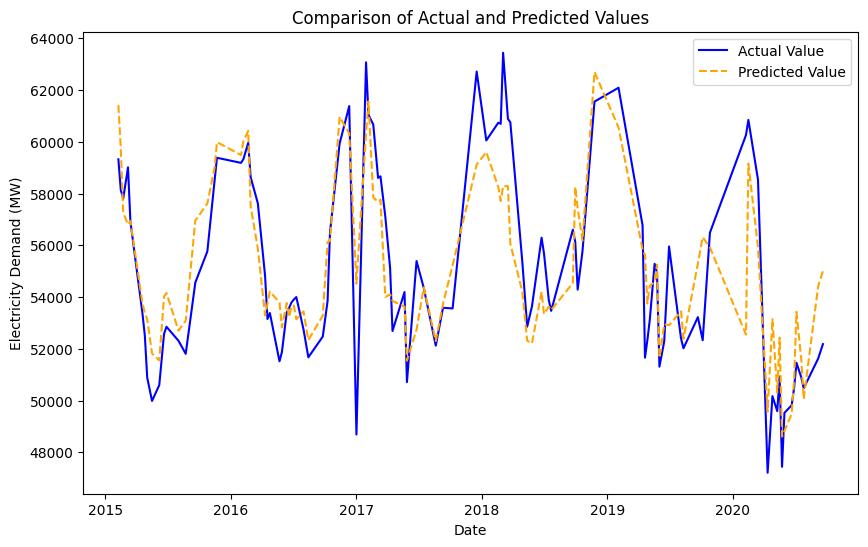

In [359]:
plt.figure(figsize=(10, 6))
plt.plot(y_test.index, y_test, label='Actual Value', color='blue')
plt.plot(y_test.index, y_pred, label='Predicted Value', color='orange', linestyle='--')
plt.title('Comparison of Actual and Predicted Values')
plt.xlabel('Date')
plt.ylabel('Electricity Demand (MW)')
plt.legend()
plt.show()

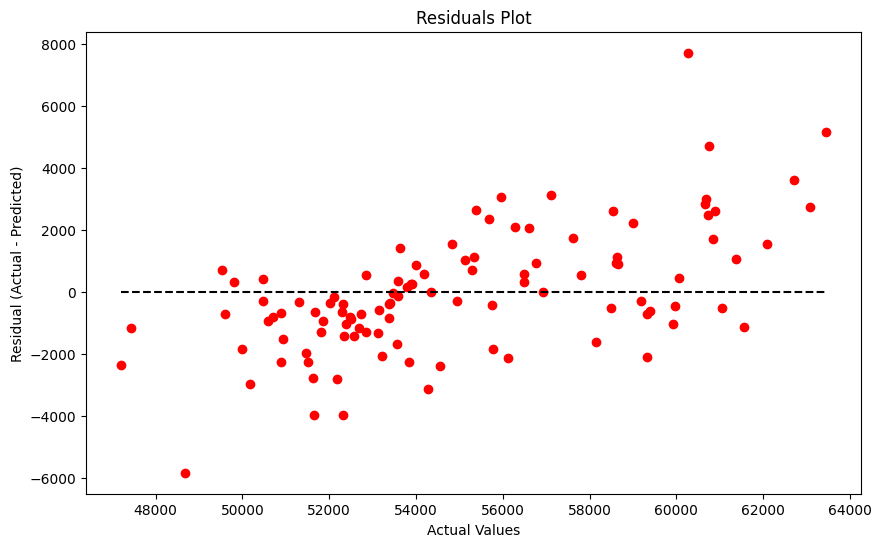

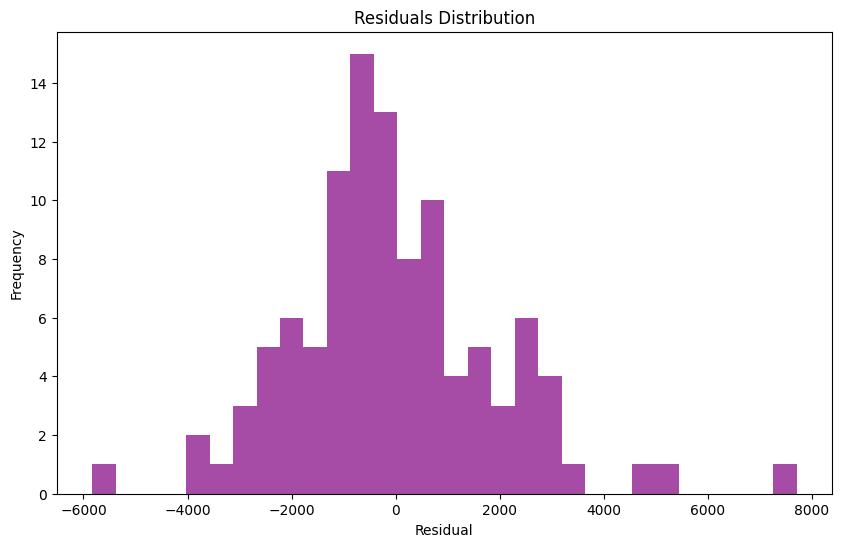

In [360]:
# Residuals plot
residuals = y_test - y_pred

plt.figure(figsize=(10, 6))
plt.scatter(y_test, residuals, color='red')
plt.hlines(y=0, xmin=min(y_test), xmax=max(y_test), color='black', linestyle='--')
plt.title('Residuals Plot')
plt.xlabel('Actual Values')
plt.ylabel('Residual (Actual - Predicted)')
plt.show()

# Histogram of residuals
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=30, color='purple', alpha=0.7)
plt.title('Residuals Distribution')
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.show()

In [361]:
# Calculate performance metrics
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)

C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [362]:
print(f"Mean Absolute Error (MAE) on test set: {mae} MW")
print(f"Root Mean Squared Error (RMSE) on test set: {rmse}")

Mean Absolute Error (MAE) on test set: 1497.1959740706425 MW
Root Mean Squared Error (RMSE) on test set: 1985.0238513737131


In [363]:
# Calculate the average value of actual electricity consumption
mean_real_load = data['DE_load_actual_entsoe_transparency'].mean()


In [364]:
# Calculate the percentage of MAE and RMSE relative to the average demand value
mae_percentage = (mae / mean_real_load) * 100
rmse_percentage = (rmse / mean_real_load) * 100

In [365]:
print(f"The MAE is {mae_percentage:.2f}% of the average electricity demand.")
print(f"The RMSE is {rmse_percentage:.2f}% of the average electricity demand.")

The MAE is 2.70% of the average electricity demand.
The RMSE is 3.58% of the average electricity demand.
